In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from veritastool.util.utility import test_function_cs
from veritastool.model import ModelContainer
from veritastool.fairness import CreditScoring
from typing import *
from sklearn.tree import DecisionTreeClassifier
from auto_ml_validation.validation_package.utils import instantiate_clf

In [ ]:
# perf_metric_name = "balanced_acc"

In [5]:
class FairnessMetricsEvaluator:
    
    def __init__(self,
                 train_data: Dict[str, Union[pd.DataFrame, np.ndarray]],
                 test_data: Dict[str, Union[pd.DataFrame, np.ndarray]],
                 threshold: float,
                 cat_var_list: List[str],
                 algo: str,
                 params: Dict,
                 prot_cat_var_value: Dict[str,List[str]], 
                 fairthreshold: float,
                 perf_metric_name: str,
                 fair_metric_name: str
                ):
            self.train_raw_X = train_data['raw_X']
            self.train_y = train_data['y']
            self.train_proba = train_data['pred_proba']
            self.test_raw_X = test_data['raw_X']
            self.test_y = test_data['y']
            self.test_proba = test_data['pred_proba']
            self.threshold = threshold
            self.cat_var_list = cat_var_list
            self.algo = algo
            self.params = params
            self.prot_cat_var_value = prot_cat_var_value
            self.fairthreshold = fairthreshold
            self.perf_metric_name = perf_metric_name
            self.fair_metric_name = fair_metric_name
    
    def fairness_visualization(self):
        """
        X_train : All the feature values in training set.
        X_test : All the feature values in testing set.
        y_true : Ground truth target values.
        y_pred : Predicted targets as returned by classifier.
        y_train : Ground truth for training data.
        y_prob : Predicted probabilities as returned by classifier. 
        cat_var_list: list of names for all the categorical variable. 
        prot_cat_var_value: a python dict where the key is string and value is a list of string. 
        model : an sklearn pipeline object. 
        """

        test_function_cs()

        # pass in the data and model info
        y_pred = self.test_proba.apply(lambda x: 1 if x>=self.threshold else 0)
        p_var = self.cat_var_list
        p_grp = self.prot_cat_var_value
        model_object = instantiate_clf(self.algo, self.params)
        
        container = ModelContainer(y_true = self.test_y, 
                                   y_train = self.train_y, 
                                   p_var = p_var, 
                                   p_grp = p_grp, 
                                   x_train = self.train_raw_X,  
                                   x_test = self.test_raw_X, 
                                   model_object = model_object, 
                                   y_pred= y_pred, 
                                   y_prob= self.test_proba,
                                   model_type = 'credit')

        cre_sco_obj= CreditScoring(model_params = [container], 
                                   fair_threshold = self.fairthreshold, 
                                   fair_concern = "eligible", 
                                   fair_priority = "benefit", 
                                   fair_impact = "significant", 
                                   perf_metric_name = self.perf_metric_name, 
                                   fair_metric_name = self.fair_metric_name) 
        
        cre_sco_obj.evaluate()
        
        cre_sco_obj.evaluate(visualize = True)   
        
        cre_sco_obj.tradeoff()

### Function Testing 

In [14]:
test_set = pd.read_csv('../../../data/stage_2/loanstats_2019Q1_test.csv', index_col = False)
train_set = pd.read_csv('../../../data/stage_2/loanstats_2019Q1_train.csv', index_col = False)
test_prob = pd.read_csv('../../../data/stage_2/loanstats_test_proba.csv', index_col = False)
train_prob = pd.read_csv('../../../data/stage_2/loanstats_train_proba.csv', index_col = False)
train_set['probability'] = train_prob['probability']
test_set['probability'] = test_prob['probability']

In [15]:
train_set.loc[(train_set['probability'] >= 0.5), 'pred_label'] = 1
train_set.loc[(train_set['probability'] < 0.5), 'pred_label'] = 0
test_set.loc[(test_set['probability'] >= 0.5), 'pred_label'] = 1
test_set.loc[(test_set['probability'] < 0.5), 'pred_label'] = 0

In [16]:
all_feature_list = ['loan_amnt', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status','dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'application_type', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag']
X_train = train_set[all_feature_list]
X_test = test_set[all_feature_list]

In [17]:
train_data = {'raw_X': X_train,
             'y': train_set['loan_status'],
             'pred_proba': train_set['probability']}
test_data = {'raw_X': X_test,
             'y': test_set['loan_status'],
             'pred_proba': test_set['probability']}

In [22]:
test_class = FairnessMetricsEvaluator(train_data,
                                      test_data,
                                      0.5,
                                      ["home_ownership", "verification_status",
                                       "initial_list_status", "application_type"],
                                      'rf',
                                      {
                                                "n_estimators": 100,
                                                "criterion": "gini",
                                                "max_depth": 8,
                                                "random_state": 42,
                                                "class_weight": "balanced"
                                            },
                                      {'home_ownership': ['RENT'], 
                                       'verification_status':['Not Verified'], 
                                       'initial_list_status':['w'],
                                       "application_type":['Individual']
                                      },
                                      0.5,
                                      "balanced_acc", 
                                      "equal_opportunity"
)               

In [23]:
test_class.fairness_visualization()

Evaluate: 100%|██████████            


Traceback (most recent call last):
  File "/Users/user/Library/Caches/pypoetry/virtualenvs/auto-ml-validation-p6bMHpIF-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/yg/y3zn0b9d0_b62k1lsc72d0m80000gn/T/ipykernel_42561/701566926.py", line 1, in <module>
  File "/var/folders/yg/y3zn0b9d0_b62k1lsc72d0m80000gn/T/ipykernel_42561/568081994.py", line 49, in fairness_visualization
NameError: name 'instantiate_clf' is not defined


The test results are abnormal


In [107]:
type(train_set['score'][0])

numpy.float64

In [108]:
train_set['loan_status']

0        0
1        0
2        0
3        0
4        0
        ..
58142    0
58143    0
58144    0
58145    0
58146    0
Name: loan_status, Length: 58147, dtype: int64

In [109]:
train_set.loc[(train_set['score'] >= 0.5), 'pred_label'] = 1
train_set.loc[(train_set['score'] < 0.5), 'pred_label'] = 0
test_set.loc[(test_set['score'] >= 0.5), 'pred_label'] = 1
test_set.loc[(test_set['score'] < 0.5), 'pred_label'] = 0

In [110]:
train_set['loan_status'].unique()

array([0, 1])

In [111]:
train_set['pred_label'].unique()

array([0., 1.])

In [112]:
train_set.rename(columns={'loan_status': 'label_value', 'loan_status': 'label_value'}, inplace=True)
test_set.rename(columns={'loan_status': 'label_value', 'loan_status': 'label_value'}, inplace=True)
train_set['label_value'].unique()

array([0, 1])

In [121]:
test_set['label_value'].value_counts()

0    14461
1       76
Name: label_value, dtype: int64

In [122]:
test_set['pred_label'].value_counts()

0.0    14483
1.0       54
Name: pred_label, dtype: int64

#### Prepare data for creating class

In [30]:
X_train = train_set[['loan_amnt', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status','dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'application_type', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag']]
X_test = test_set[['loan_amnt', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status','dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'application_type', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag']]

In [124]:
y_train = train_set['label_value']
y_test = test_set['label_value']
y_prob = test_set['score']
y_pred = test_set['pred_label']

In [ ]:
xgb_test_proba.csv

In [131]:
my_class = FairnessMetricsEvaluator(train_set, test_set, 
                                    ['home_ownership', 'verification_status','initial_list_status'],
                                    Pipeline(steps=[('scaling', StandardScaler()), ('model', LogisticRegression(C=0.1, max_iter=4000, random_state=0))]))

In [126]:
train_df, test_df = my_class.data_preprocess('score','label_value')

In [127]:
train_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,label_value,dti,delinq_2yrs,inq_last_6mths,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,score,pred_label
0,9000.00-15000.00,0.09-0.12,265.73-404.88,RENT,51000.00-73000.00,Verified,0,13.85-19.70,0.00-18.00,0.00-1.00,...,0.00-4.00,0,3600.00-66923.50,36.00-26593.00,100.00-11700.00,22656.50-41817.00,N,N,0.208799,0.00-1.00
1,24000.00-40000.00,0.12-0.16,648.45-1676.23,MORTGAGE,73000.00-105000.00,Source Verified,0,26.64-999.00,0.00-18.00,0.00-1.00,...,0.00-4.00,0,147588.00-304134.00,45454.00-76693.50,39400.00-509400.00,72327.00-1230190.00,N,N,0.183391,0.00-1.00
2,1000.00-9000.00,0.09-0.12,30.64-265.73,OWN,40.00-51000.00,Not Verified,0,19.70-26.64,0.00-18.00,0.00-1.00,...,0.00-4.00,0,3600.00-66923.50,36.00-26593.00,11700.00-22100.00,22656.50-41817.00,N,N,0.168946,0.00-1.00
3,15000.00-24000.00,0.16-0.31,404.88-648.45,RENT,40.00-51000.00,Not Verified,0,19.70-26.64,0.00-18.00,0.00-1.00,...,0.00-4.00,0,66923.50-147588.00,36.00-26593.00,39400.00-509400.00,0.00-22656.50,N,N,0.075869,0.00-1.00
4,1000.00-9000.00,0.16-0.31,30.64-265.73,OWN,40.00-51000.00,Verified,0,26.64-999.00,0.00-18.00,0.00-1.00,...,0.00-4.00,0,66923.50-147588.00,76693.50-1012682.00,100.00-11700.00,72327.00-1230190.00,N,N,0.190298,0.00-1.00


    model_id score_threshold  k       attribute_name    attribute_value  tpr  \
0          0      binary 0/1  0            loan_amnt    1000.00-9000.00  0.0   
1          0      binary 0/1  0            loan_amnt  15000.00-24000.00  0.0   
2          0      binary 0/1  0            loan_amnt  24000.00-40000.00  0.0   
3          0      binary 0/1  0            loan_amnt   9000.00-15000.00  0.0   
4          0      binary 0/1  0  verification_status       Not Verified  0.0   
5          0      binary 0/1  0  verification_status    Source Verified  0.0   
6          0      binary 0/1  0  verification_status           Verified  0.0   
7          0      binary 0/1  0             int_rate          0.06-0.09  0.0   
8          0      binary 0/1  0             int_rate          0.09-0.12  0.0   
9          0      binary 0/1  0             int_rate          0.12-0.16  0.0   
10         0      binary 0/1  0             int_rate          0.16-0.31  0.0   

    tnr       for  fdr  fpr  ...  pprev

<AxesSubplot:title={'center':'TNR (Model 0)'}, xlabel='Absolute Metric Magnitude'>

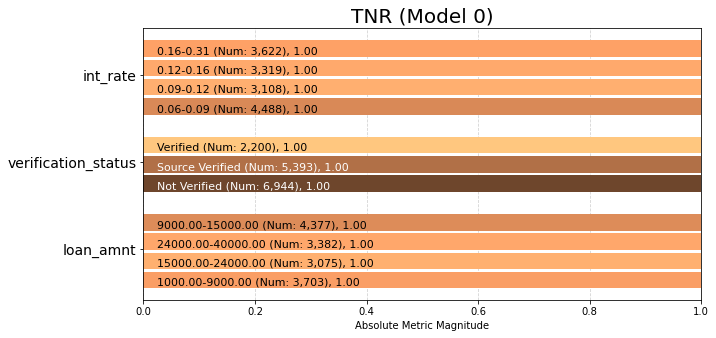

In [128]:
my_class.plot_group_metric(test_df[['loan_amnt','verification_status','int_rate','score','label_value']], 
                           'tnr')

In [129]:
my_class.fairness_visualization(X_train, X_test, y_test, y_pred, y_train, y_prob, 
                       {'home_ownership': ['RENT'], 'verification_status':['Not Verified'], 'initial_list_status':['w']})


Evaluate performance:   0%|          


Evaluation of credit scoring performed normally


Evaluate performance:   0%|          


Class Distribution
	pos_label                                                           0.523%
	neg_label                                                          99.477%


Performance Metrics
	Selection Rate                                             0.004 +/- 0.001
	Accuracy                                                   0.996 +/- 0.001
	Balanced Accuracy                                          0.723 +/- 0.068
	Recall                                                     0.447 +/- 0.136
	Precision                                                  0.630 +/- 0.134
	F1 Score                                                   0.523 +/- 0.125
	True Negative Rate                                         0.999 +/- 0.001
	False Negative Rate                                        0.553 +/- 0.136
	Negative Predictive Value                                  0.997 +/- 0.001
	ROC AUC Score                                              0.823 +/- 0.061
	Log-loss                                     

*The threshold and the values of ratio-based metrics are shifted down by 1.
